In [59]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm import tqdm

In [60]:
def KL_divergence_pinv(mean1, mean2, covariance1, covariance2):
    assert covariance1.shape == covariance2.shape
    d = covariance1.shape[0]
    mean1 = mean1.type(torch.float64)
    mean2 = mean2.type(torch.float64)
    covariance1 = covariance1.type(torch.float64)
    covariance2 = covariance2.type(torch.float64)
    cov1_bis = covariance1 + torch.eye(1024, device='cuda:0') * 1e-6
    cov2_bis = covariance2 + torch.eye(1024, device='cuda:0') * 1e-6
    product1 = cov2_bis @ torch.linalg.pinv(cov1_bis, atol=1e-7, hermitian=True)
    product2 = covariance2 @ torch.linalg.pinv(covariance1, atol=1e-7, hermitian=True)
    scal_prod = torch.t(mean2 - mean1) @ torch.linalg.pinv(covariance2, atol=1e-6, hermitian=True) @ (mean2 - mean1)
    lndet = torch.logdet(product1)
    trace = torch.trace(product2) + (
            1024 - torch.linalg.matrix_rank(torch.linalg.pinv(covariance1, atol=1e-7, hermitian=True)))
    return lndet, trace, scal_prod, 1 / 2 * (lndet - d + trace + scal_prod)

In [61]:
def KL_divergence(mean1, mean2, covariance1, covariance2):
    assert covariance1.shape == covariance2.shape
    d = covariance1.shape[0]
    mean1 = mean1.type(torch.float64)
    mean2 = mean2.type(torch.float64)
    covariance1 = covariance1.type(torch.float64)
    covariance2 = covariance2.type(torch.float64)
    product = covariance2 @ torch.linalg.inv(covariance1)
    scal_prod = torch.t(mean2 - mean1) @ torch.linalg.inv(covariance2) @ (mean2 - mean1)
    print(torch.logdet(product))
    print(torch.trace(product))
    print(scal_prod)
    return 1 / 2 * torch.logdet(product) - d / 2 + 1 / 2 * torch.trace(product) + 1 / 2 * scal_prod

In [62]:
def KL_divergence_std(mean1, mean2, variance1, variance2):
    assert variance1.shape == variance2.shape
    d = variance1.shape[0]
    mean1 = mean1.type(torch.float64)
    mean2 = mean2.type(torch.float64)
    variance1 = variance1.type(torch.float64) * torch.eye(d, device='cuda:0')
    variance2 = variance2.type(torch.float64) * torch.eye(d, device='cuda:0')
    product = variance2 @ torch.linalg.inv(variance1)
    scal_prod = torch.t(mean2 - mean1) @ torch.linalg.inv(variance2) @ (mean2 - mean1)
    return 1 / 2 * torch.logdet(product) - d / 2 + 1 / 2 * torch.trace(product) + 1 / 2 * scal_prod

In [63]:
paths = [os.path.join('./class_barycenter', dataset) for dataset in os.listdir('./class_barycenter')]
heatmaps = {}

In [64]:
for path in paths:
    print(path)
    mean = [x for x in sorted(os.listdir(path),
                              key=lambda item: (int(item.partition('_')[0])
                                                if item[0].isdigit() else float('inf'), item))
            if x.split('_')[1] == 'mean.pkl']

    cov = [x for x in sorted(os.listdir(path),
                             key=lambda item: (int(item.partition('_')[0])
                                               if item[0].isdigit() else float('inf'), item))
           if x.split('_')[1] == 'cov.pkl']

    n = len(mean)
    heatmap = np.zeros((n, n))

    for i in tqdm(range(n)):
        mean1_path = os.path.join(path, mean[i])
        cov1_path = os.path.join(path, cov[i])
        with open(mean1_path, 'rb') as f:
            mean1 = pickle.load(f)
        with open(cov1_path, 'rb') as f:
            covariance1 = pickle.load(f)
        for j in range(n):
            mean2_path = os.path.join(path, mean[j])
            cov2_path = os.path.join(path, cov[j])
            with open(mean2_path, 'rb') as f:
                mean2 = pickle.load(f)
            with open(cov2_path, 'rb') as f:
                covariance2 = pickle.load(f)

            # heatmap1[i, j], heatmap2[i, j], heatmap3[i, j], heatmap[i, j] = KL_divergence_pinv(mean1, mean2, covariance1, covariance2)
            try:
                heatmap[i, j] = KL_divergence_std(mean1, mean2, covariance1, covariance2)
            except torch._C._LinAlgError:
                heatmap[i, j] = np.nan
    heatmaps[path.split('/')[-1]] = heatmap

./class_barycenter/watercolor_test


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


./class_barycenter/VisDrone_test


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


./class_barycenter/watercolor_train


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


./class_barycenter/DeepFruits_val


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


./class_barycenter/Oktoberfest_test


100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


./class_barycenter/clipart_train


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


./class_barycenter/SIXray_train


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


./class_barycenter/fashionpedia_train


100%|██████████| 46/46 [03:22<00:00,  4.41s/it]


./class_barycenter/DIOR_test


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


./class_barycenter/SIXray_val


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


./class_barycenter/comic_val


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


./class_barycenter/DIOR_train


100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


./class_barycenter/comic_test


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


./class_barycenter/VisDrone_train


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


./class_barycenter/SIXray_test


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


./class_barycenter/CrowdHuman_val


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


./class_barycenter/COCO_train


100%|██████████| 80/80 [10:05<00:00,  7.57s/it]


./class_barycenter/CrowdHuman_test


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


./class_barycenter/fashionpedia_val


100%|██████████| 46/46 [03:13<00:00,  4.21s/it]


./class_barycenter/COCO_val


100%|██████████| 80/80 [09:44<00:00,  7.31s/it]


./class_barycenter/clipart_val


100%|██████████| 20/20 [00:37<00:00,  1.85s/it]


./class_barycenter/DOTA_val


100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


./class_barycenter/clipart_test


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


./class_barycenter/KITTI_val


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


./class_barycenter/Oktoberfest_train


100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


./class_barycenter/VisDrone_val


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


./class_barycenter/watercolor_val


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


./class_barycenter/DOTA_test


100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


./class_barycenter/KITTI_test


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


./class_barycenter/Oktoberfest_val


100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


./class_barycenter/comic_train


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


./class_barycenter/DeepFruits_train


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


./class_barycenter/DIOR_val


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


./class_barycenter/fashionpedia_test


100%|██████████| 46/46 [03:15<00:00,  4.26s/it]


./class_barycenter/DeepFruits_test


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


./class_barycenter/CrowdHuman_train


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


./class_barycenter/KITTI_train


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


./class_barycenter/DOTA_train


100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


In [50]:
plt.imshow(heatmaps[0])

dict_keys(['watercolor_test', 'VisDrone_test', 'watercolor_train', 'DeepFruits_val', 'Oktoberfest_test', 'clipart_train', 'SIXray_train', 'fashionpedia_train', 'DIOR_test', 'SIXray_val', 'comic_val', 'DIOR_train', 'comic_test', 'VisDrone_train', 'SIXray_test', 'CrowdHuman_val', 'COCO_train', 'CrowdHuman_test', 'fashionpedia_val', 'COCO_val', 'clipart_val', 'DOTA_val', 'clipart_test', 'KITTI_val', 'Oktoberfest_train', 'VisDrone_val', 'watercolor_val', 'DOTA_test', 'KITTI_test', 'Oktoberfest_val', 'comic_train', 'DeepFruits_train', 'DIOR_val', 'fashionpedia_test', 'DeepFruits_test', 'CrowdHuman_train', 'KITTI_train', 'DOTA_train'])

In [85]:
% matplotlib qt
fig = plt.figure()

grid = AxesGrid(fig, 111,
                nrows_ncols=(7, 6),
                axes_pad=0.5,
                share_all=True,
                cbar_location="right",
                cbar_mode="single",
                )
keys = sorted(list(heatmaps.keys()))[2:] + ['COCO_train', 'COCO_val']

for dataset, ax in zip(keys, grid):
    ax.set_title(dataset)
    im = ax.imshow(heatmaps[dataset])

grid.cbar_axes[0].colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(True)

plt.show()


In [361]:
n = len(mean)
heatmap = np.zeros((n, n))
heatmap1 = np.zeros((n, n))
heatmap2 = np.zeros((n, n))
heatmap3 = np.zeros((n, n))


In [362]:
for i in tqdm(range(n)):
    mean1_path = os.path.join(path, mean[i])
    cov1_path = os.path.join(path, cov[i])
    with open(mean1_path, 'rb') as f:
        mean1 = pickle.load(f)
    with open(cov1_path, 'rb') as f:
        covariance1 = pickle.load(f)
    for j in range(n):
        mean2_path = os.path.join(path, mean[j])
        cov2_path = os.path.join(path, cov[j])
        with open(mean2_path, 'rb') as f:
            mean2 = pickle.load(f)
        with open(cov2_path, 'rb') as f:
            covariance2 = pickle.load(f)

        # heatmap1[i, j], heatmap2[i, j], heatmap3[i, j], heatmap[i, j] = KL_divergence_pinv(mean1, mean2, covariance1, covariance2)
        heatmap[i, j] = KL_divergence_std(mean1, mean2, covariance1, covariance2)

100%|██████████| 80/80 [09:53<00:00,  7.42s/it]


In [84]:
% matplotlib qt

plt.imshow(heatmap)

UsageError: Line magic function `%` not found.


In [312]:
plt.imshow(heatmap1)

In [313]:
plt.imshow(heatmap2)

In [314]:
plt.imshow(heatmap3)

In [48]:
path = './class_barycenter/COCO_train'
mean = [x for x in sorted(os.listdir(path),
                          key=lambda item: (int(item.partition('_')[0])
                                            if item[0].isdigit() else float('inf'), item))
        if x.split('_')[1] == 'mean.pkl']

cov = [x for x in sorted(os.listdir(path),
                         key=lambda item: (int(item.partition('_')[0])
                                           if item[0].isdigit() else float('inf'), item))
       if x.split('_')[1] == 'cov.pkl']

In [49]:
mean1_path = os.path.join(path, mean[70])
cov1_path = os.path.join(path, cov[70])
with open(mean1_path, 'rb') as f:
    mean1 = pickle.load(f)
with open(cov1_path, 'rb') as f:
    covariance1 = pickle.load(f)

mean2_path = os.path.join(path, mean[0])
cov2_path = os.path.join(path, cov[0])
with open(mean2_path, 'rb') as f:
    mean2 = pickle.load(f)
with open(cov2_path, 'rb') as f:
    covariance2 = pickle.load(f)

In [50]:
mean1 = mean1.type(torch.float64)
mean2 = mean2.type(torch.float64)
covariance1 = covariance1.type(torch.float64)
covariance2 = covariance2.type(torch.float64)

In [51]:
np.isclose(np.linalg.eig(covariance1.cpu().numpy())[0], np.zeros(1024)).sum()

48

In [355]:
KL_divergence(mean1, mean2, covariance1, covariance2)

tensor(1177.1431, device='cuda:0', dtype=torch.float64)
tensor(9070.5505, device='cuda:0', dtype=torch.float64)
tensor(144.7316, device='cuda:0', dtype=torch.float64)


tensor(4684.2126, device='cuda:0', dtype=torch.float64)

In [333]:
KL_divergence_pinv(mean1, mean2, covariance1, covariance2)

(tensor(-6.2382e-09, device='cuda:0', dtype=torch.float64),
 tensor(347.0000, device='cuda:0', dtype=torch.float64),
 tensor(0., device='cuda:0', dtype=torch.float64),
 tensor(-338.5000, device='cuda:0', dtype=torch.float64))

In [356]:
KL_divergence_std(mean1, mean2, covariance1, covariance2)

tensor(1837.1026, device='cuda:0', dtype=torch.float64)

In [337]:
product2 = covariance2 @ torch.linalg.pinv(covariance1, atol=1e-7, hermitian=True)
trace = torch.trace(product2) + (
        1024 - torch.linalg.matrix_rank(torch.linalg.pinv(covariance1, atol=1e-7, hermitian=True)))

In [339]:
trace

tensor(1024.0000, device='cuda:0', dtype=torch.float64)

tensor(1024.0000, device='cuda:0', dtype=torch.float64)

In [116]:
paths = sorted(os.path.join('./class_barycenter', dataset) for dataset in os.listdir('./class_barycenter'))
for path in paths:
    print(path.split('/')[-1])

    cov = [x for x in sorted(os.listdir(path),
                             key=lambda item: (int(item.partition('_')[0])
                                               if item[0].isdigit() else float('inf'), item))
           if x.split('_')[1] == 'cov.pkl']

    n = len(cov)

    for i in range(n):
        cov1_path = os.path.join(path, cov[i])
        with open(cov1_path, 'rb') as f:
            covariance1 = pickle.load(f)

        variance1 = np.array([covariance1[i, i].cpu().numpy() for i in range(len(covariance1))])

        try:
            print(
                i,
                (np.linalg.eig(covariance1.cpu().numpy())[0] <= np.linalg.eig(covariance1.cpu().numpy())[
                    0].max() * 0.001).sum()
            )
        except np.linalg.LinAlgError:
            print(i)


COCO_train
0 832
1 843
2 795


KeyboardInterrupt: 

In [111]:
(np.linalg.eig(covariance1.cpu().numpy())[0] > 5).sum()

15

In [22]:
with open(cov1_path, 'rb') as f:
    covariance1 = pickle.load(f)

In [88]:
with open('./dataset_barycenter/COCO_train_std.pkl', 'rb') as f:
    cov = pickle.load(f)

In [89]:
cov.shape

torch.Size([1024, 1024])

In [95]:
os.listdir('./dataset_barycenter')

np.isclose(np.linalg.eig(cov.cpu().numpy())[0], np.zeros(cov.shape[0]), atol=1e-6).sum()

0

In [117]:
path = './dataset_barycenter'

cov = [x for x in sorted(os.listdir(path)) if x.split('_')[-1] == 'std.pkl']

for dataset in cov:
    cov_path = os.path.join(path, dataset)
    with open(cov_path, 'rb') as f:
        covariance = pickle.load(f)

    variance = np.array([covariance[i, i].cpu().numpy() for i in range(len(covariance))])

    print(
        dataset,
        (np.linalg.eig(covariance.cpu().numpy())[0] <= np.linalg.eig(covariance.cpu().numpy())[0].max() * 0.001).sum()
    )


COCO_train_std.pkl 899
COCO_val_std.pkl 900
CrowdHuman_test_std.pkl 936
CrowdHuman_train_std.pkl 939
CrowdHuman_val_std.pkl 940
DIOR_test_std.pkl 888
DIOR_train_std.pkl 885
DIOR_val_std.pkl 888
DOTA_test_std.pkl 886
DOTA_train_std.pkl 877
DOTA_val_std.pkl 878
DeepFruits_test_std.pkl 956
DeepFruits_train_std.pkl 931
DeepFruits_val_std.pkl 1006
KITTI_test_std.pkl 946
KITTI_train_std.pkl 942
KITTI_val_std.pkl 935
Oktoberfest_test_std.pkl 965
Oktoberfest_train_std.pkl 948
Oktoberfest_val_std.pkl 954
SIXray_test_std.pkl 950
SIXray_train_std.pkl 950
SIXray_val_std.pkl 953
VisDrone_test_std.pkl 930
VisDrone_train_std.pkl 915
VisDrone_val_std.pkl 916
clipart_test_std.pkl 877
clipart_train_std.pkl 869
clipart_val_std.pkl 926
comic_test_std.pkl 931
comic_train_std.pkl 885
comic_val_std.pkl 933
fashionpedia_test_std.pkl 885
fashionpedia_train_std.pkl 886
fashionpedia_val_std.pkl 892
watercolor_test_std.pkl 929
watercolor_train_std.pkl 885
watercolor_val_std.pkl 933


In [42]:
prop_eig0 = [773.45, 703.25, 808.60,
             776.25, 716.19, 833.06,
             968.71, 872.29, 1002.20,
             888.60, 834.20, 887.00,
             970.85, 976.40, 1007.89]
             # 549.80, 549.80, 684.40]

perf_5shot = [30.42, 30.42, 30.42,
              14.45, 14.45, 14.45,
              55.58, 55.58, 55.58,
              13.25, 13.25, 13.25,
              5.26, 5.26, 5.26]
              # 5.74, 5.74, 5.74]

labels = ['DIOR_test', 'DIOR_train', 'DIOR_val',
          'DOTA_test', 'DOTA_train', 'DOTA_val',
          'DeepFruits_test', 'DeepFruits_train', 'DeepFruits_val',
          'SIXray_test', 'SIXray_train', 'SIXray_val',
          'clipart_test', 'clipart_train', 'clipart_val']
          # 'VisDrone_test', 'VisDrone_train', 'VisDrone_val']

In [28]:
colors_dict = {'COCO': '#9D6FD7',
               'CrowdHuman': '#E6C8C7',
               'DIOR': '#003A37',
               'DOTA': '#8AFF66',
               'DeepFruits': '#284D26',
               'KITTI': '#F65794',
               'Oktoberfest': '#804E96',
               'SIXray': '#C05E5A',
               'VisDrone': '#458BBC',
               'clipart': '#C83F0F',
               'comic': '#3C7503',
               'fashionpedia': '#3B9F21',
               'watercolor': '#E68C70'}

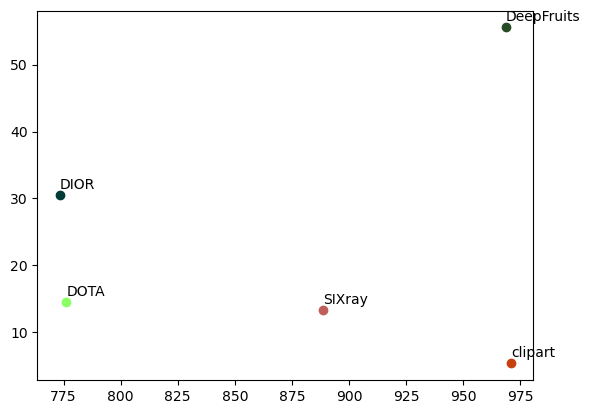

In [43]:
for prop, perf, label in zip(prop_eig0, perf_5shot, labels):
    if label.split('_')[-1] == 'test':
        plt.scatter(prop, perf, color=colors_dict[label.split('_')[0]])
        plt.text(prop, perf + 1, label.split('_')[0])
plt.show()

In [48]:
prop_eig0 = [970.85, 976.40, 1007.89,
             856.00, 860.00, 862.00,
             968.71, 872.29, 1002.20,
             891.89, 872.17, 949.87,
             855.00, 836.50, 856.75,
             1009.33, 925.73, 992.07,
             888.60, 834.20, 887.00]
             # 549.80, 549.80, 684.40]

perf_5shot = [49.3, 49.3, 49.3,
              51.5, 51.5, 51.5,
              60.7, 60.7, 60.7,
              21.3, 21.3, 21.3,
              45.3, 45.3, 45.3,
              81.6, 81.6, 81.6,
              23.9, 23.9, 23.9]
              # 14.2, 14.2, 14.2]

labels = ['clipart_test', 'clipart_train', 'clipart_val',
          'CrowdHuman_test', 'CrowdHuman_train', 'CrowdHuman_val',
          'DeepFruits_test', 'DeepFruits_train', 'DeepFruits_val',
          'fashionpedia_test', 'fashionpedia_train', 'fashionpedia_val',
          'KITTI_test', 'KITTI_train', 'KITTI',
          'Oktoberfest_test', 'Oktoberfest_train', 'Oktoberfest_val',
          'SIXray_test', 'SIXray_train', 'SIXray_val']
          # 'VisDrone_test', 'VisDrone_train', 'VisDrone_val']

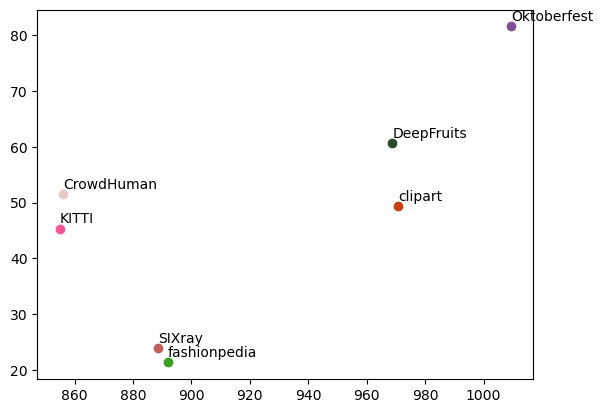

In [49]:
for prop, perf, label in zip(prop_eig0, perf_5shot, labels):
    if label.split('_')[-1] == 'test':
        plt.scatter(prop, perf, color=colors_dict[label.split('_')[0]])
        plt.text(prop, perf + 1, label.split('_')[0])
plt.show()